# **Generating Images**
# **FCN**

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers

In [2]:
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images.shape

4422102/4422102 [==============================] - 1s 0us/step


(60000, 28, 28)

In [3]:
# reshaping for NN
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images.shape

(60000, 28, 28, 1)

In [4]:
train_images = (train_images - 127.5) / 127.5
print(train_images.min(), "---",train_images.max())

-1.0 --- 1.0


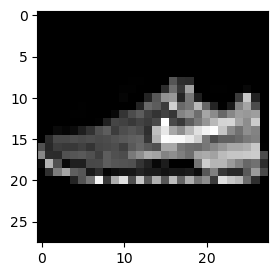

In [5]:
plt.figure(figsize=(3, 3))
plt.imshow(train_images[2567].squeeze(), cmap = 'gray')

In [6]:
buffer_size = 60000
batch_size = 128


In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

\newpage

# Genetator

In [8]:
def generator_model():
   
    model = tf.keras.Sequential()
    model.add(layers.Dense(64, input_dim = 100)) # noise input dims
    model.add(layers.ReLU())
   
    model.add(layers.Dense(128))
    model.add(layers.ReLU())
    
    model.add(layers.Dense(256))
    model.add(layers.ReLU()) 

    model.add(layers.Dense(784, activation = 'tanh')) 
    model.add(layers.Reshape((28, 28, 1)))
    
    return model


In [9]:
generator = generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                6464      
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 re_lu_1 (ReLU)              (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 re_lu_2 (ReLU)              (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 784)               2

In [10]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training = False)

generated_image.shape


TensorShape([1, 28, 28, 1])

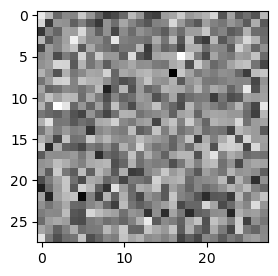

In [11]:
plt.figure(figsize=(3, 3))
plt.imshow(generated_image[0, :, :, 0], cmap = 'gray')

\newpage

# Discriminator

In [12]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape = (28, 28, 1)))
    model.add(layers.Flatten())
  
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model

In [13]:
discriminator = discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               200960    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)              

In [14]:
discriminator = discriminator_model()
output = discriminator(generated_image)
print (output)

tf.Tensor([[0.49916857]], shape=(1, 1), dtype=float32)


# Loss and Optimizer

In [15]:
bce = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss    
    return total_loss

In [16]:
def generator_loss(fake_output):
    gen_loss = bce(tf.ones_like(fake_output), fake_output)
    return gen_loss

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001 )
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001 )

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

# Training

In [19]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [20]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))

\newpage

In [21]:
def generate_and_plot_images(model, epoch, test_input):
  
    predictions = model(test_input, training = False)

    fig = plt.figure(figsize = (6, 3))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)  
        pred = (predictions[i, :, :, 0] + 1) * 127.5  
        pred = np.array(pred)    
        plt.imshow(pred.astype(np.uint8), cmap = 'gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

\newpage

In [22]:
def train(dataset, epochs):
    
    gen_loss_list = []
    disc_loss_list = []
    
    real_score_list =[]
    fake_score_list =[]
    for epoch in tqdm(range(epochs)):
        start = time.time()
        num_batches = len(dataset)
        
        print(f'Training started with  epoch {epoch + 1} with {num_batches} batches...')
        
        total_gen_loss = 0
        total_disc_loss = 0
        
        for batch in dataset:
            generator_loss, discriminator_loss, real_score, fake_score = train_step(batch)
            total_gen_loss += generator_loss
            total_disc_loss += discriminator_loss
        
        mean_gen_loss = total_gen_loss / num_batches
        mean_disc_loss = total_disc_loss / num_batches
           
        print('Losses after epoch %5d: generator %.3f, discriminator %.3f, real_score %.2f%%, fake_score %.2f%%'  %
              (epoch + 1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))

        generate_and_plot_images(generator, epoch + 1, seed)                 

        gen_loss_list.append(mean_gen_loss)
        disc_loss_list.append(mean_disc_loss)
        real_score_list.append(real_score)
        fake_score_list.append(fake_score)

        if (epoch + 1) % 10 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  
    return  gen_loss_list, disc_loss_list, real_score_list, fake_score_list              


  0%|          | 0/50 [00:00<?, ?it/s]

Training started with  epoch 1 with 469 batches...
Losses after epoch     1: generator 3.087, discriminator 0.516, real_score 88.98%, fake_score 15.87%


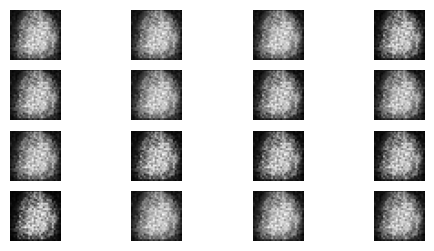

  2%|▏         | 1/50 [00:07<06:19,  7.74s/it]

Time for epoch 1 is 7.7369678020477295 sec
Training started with  epoch 2 with 469 batches...
Losses after epoch     2: generator 11.111, discriminator 0.224, real_score 96.27%, fake_score 4.37%


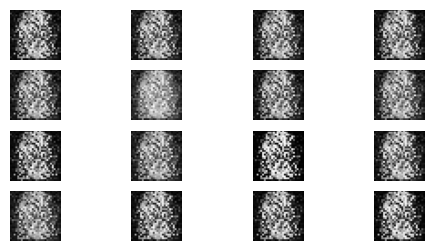

  4%|▍         | 2/50 [00:10<03:39,  4.58s/it]

Time for epoch 2 is 2.3544435501098633 sec
Training started with  epoch 3 with 469 batches...
Losses after epoch     3: generator 2.400, discriminator 0.361, real_score 92.01%, fake_score 17.43%


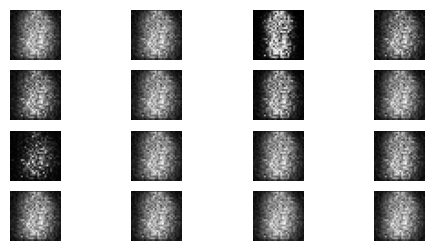

  6%|▌         | 3/50 [00:12<02:52,  3.67s/it]

Time for epoch 3 is 2.5880541801452637 sec
Training started with  epoch 4 with 469 batches...
Losses after epoch     4: generator 2.070, discriminator 0.732, real_score 85.70%, fake_score 19.98%


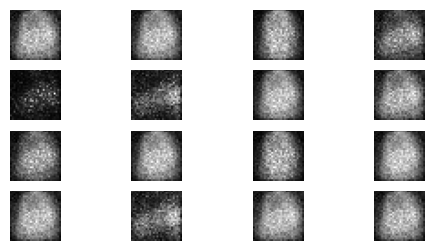

  8%|▊         | 4/50 [00:15<02:24,  3.14s/it]

Time for epoch 4 is 2.3256208896636963 sec
Training started with  epoch 5 with 469 batches...
Losses after epoch     5: generator 3.005, discriminator 0.478, real_score 82.65%, fake_score 13.89%


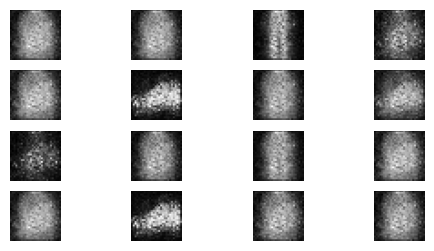

 10%|█         | 5/50 [00:17<02:13,  2.97s/it]

Time for epoch 5 is 2.6616251468658447 sec
Training started with  epoch 6 with 469 batches...
Losses after epoch     6: generator 3.712, discriminator 0.378, real_score 87.99%, fake_score 11.82%


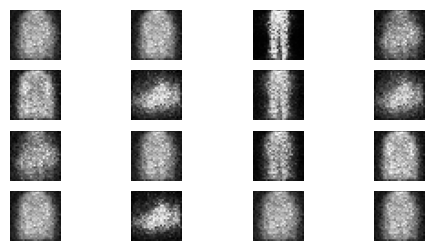

 12%|█▏        | 6/50 [00:20<02:01,  2.77s/it]

Time for epoch 6 is 2.373401165008545 sec
Training started with  epoch 7 with 469 batches...
Losses after epoch     7: generator 2.727, discriminator 0.388, real_score 90.83%, fake_score 14.38%


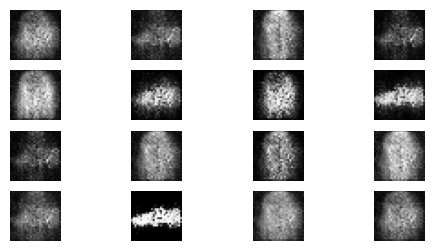

 14%|█▍        | 7/50 [00:22<01:52,  2.62s/it]

Time for epoch 7 is 2.3164737224578857 sec
Training started with  epoch 8 with 469 batches...
Losses after epoch     8: generator 2.331, discriminator 0.539, real_score 87.95%, fake_score 20.44%


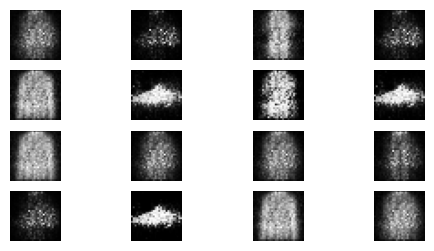

 16%|█▌        | 8/50 [00:24<01:49,  2.60s/it]

Time for epoch 8 is 2.5652904510498047 sec
Training started with  epoch 9 with 469 batches...
Losses after epoch     9: generator 1.776, discriminator 0.752, real_score 75.59%, fake_score 24.47%


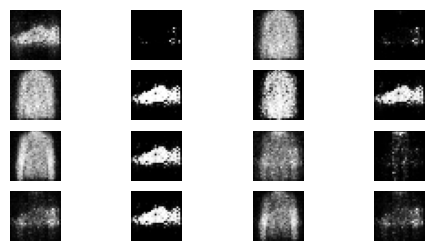

 18%|█▊        | 9/50 [00:27<01:43,  2.53s/it]

Time for epoch 9 is 2.378350019454956 sec
Training started with  epoch 10 with 469 batches...
Losses after epoch    10: generator 2.568, discriminator 0.423, real_score 86.09%, fake_score 15.25%


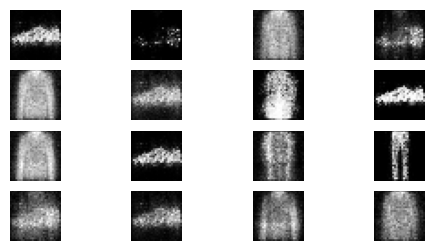

 20%|██        | 10/50 [00:30<01:43,  2.59s/it]

Time for epoch 10 is 2.725480556488037 sec
Training started with  epoch 11 with 469 batches...
Losses after epoch    11: generator 3.133, discriminator 0.324, real_score 90.38%, fake_score 9.78%


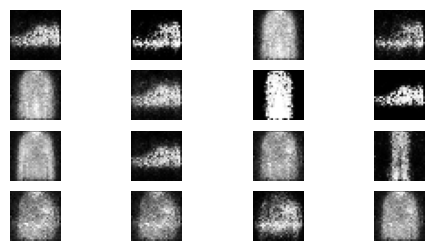

 22%|██▏       | 11/50 [00:32<01:40,  2.57s/it]

Time for epoch 11 is 2.5243263244628906 sec
Training started with  epoch 12 with 469 batches...
Losses after epoch    12: generator 2.611, discriminator 0.534, real_score 84.39%, fake_score 15.51%


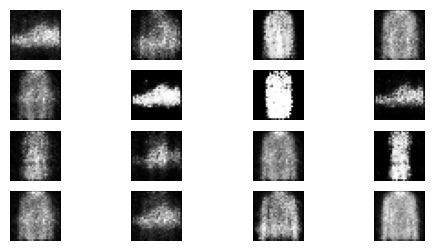

 24%|██▍       | 12/50 [00:35<01:40,  2.64s/it]

Time for epoch 12 is 2.7872209548950195 sec
Training started with  epoch 13 with 469 batches...
Losses after epoch    13: generator 2.746, discriminator 0.487, real_score 83.25%, fake_score 12.51%


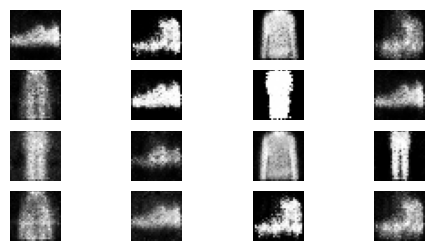

 26%|██▌       | 13/50 [00:37<01:35,  2.58s/it]

Time for epoch 13 is 2.4541590213775635 sec
Training started with  epoch 14 with 469 batches...
Losses after epoch    14: generator 1.981, discriminator 0.718, real_score 74.05%, fake_score 19.35%


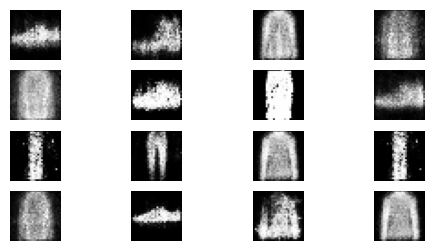

 28%|██▊       | 14/50 [00:40<01:31,  2.54s/it]

Time for epoch 14 is 2.4458420276641846 sec
Training started with  epoch 15 with 469 batches...
Losses after epoch    15: generator 2.094, discriminator 0.553, real_score 82.66%, fake_score 19.07%


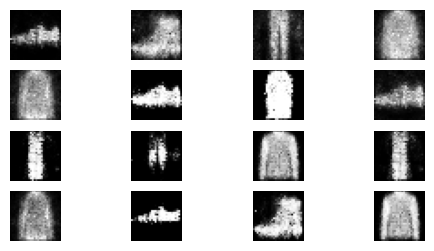

 30%|███       | 15/50 [00:42<01:27,  2.51s/it]

Time for epoch 15 is 2.4388046264648438 sec
Training started with  epoch 16 with 469 batches...
Losses after epoch    16: generator 1.643, discriminator 0.724, real_score 75.95%, fake_score 26.69%


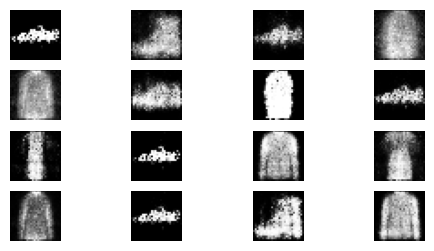

 32%|███▏      | 16/50 [00:45<01:26,  2.55s/it]

Time for epoch 16 is 2.640594005584717 sec
Training started with  epoch 17 with 469 batches...
Losses after epoch    17: generator 2.657, discriminator 0.577, real_score 78.83%, fake_score 16.89%


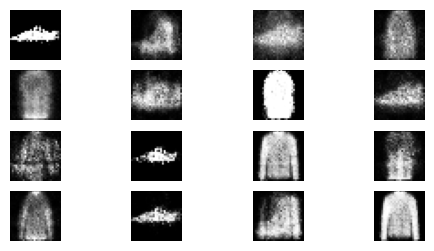

 34%|███▍      | 17/50 [00:47<01:22,  2.50s/it]

Time for epoch 17 is 2.359851121902466 sec
Training started with  epoch 18 with 469 batches...
Losses after epoch    18: generator 2.131, discriminator 0.498, real_score 84.65%, fake_score 19.33%


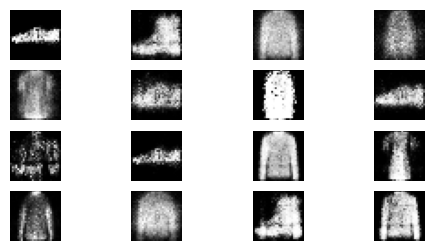

 36%|███▌      | 18/50 [00:50<01:18,  2.47s/it]

Time for epoch 18 is 2.391254186630249 sec
Training started with  epoch 19 with 469 batches...
Losses after epoch    19: generator 2.178, discriminator 0.664, real_score 77.93%, fake_score 20.35%


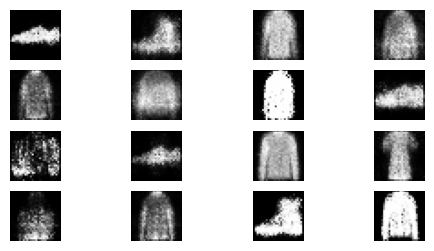

 38%|███▊      | 19/50 [00:52<01:15,  2.43s/it]

Time for epoch 19 is 2.350334405899048 sec
Training started with  epoch 20 with 469 batches...
Losses after epoch    20: generator 2.431, discriminator 0.681, real_score 79.02%, fake_score 17.88%


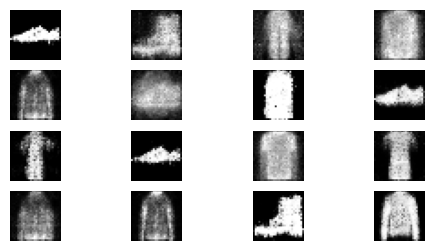

 40%|████      | 20/50 [00:54<01:13,  2.44s/it]

Time for epoch 20 is 2.4655377864837646 sec
Training started with  epoch 21 with 469 batches...
Losses after epoch    21: generator 1.758, discriminator 0.676, real_score 81.16%, fake_score 25.86%


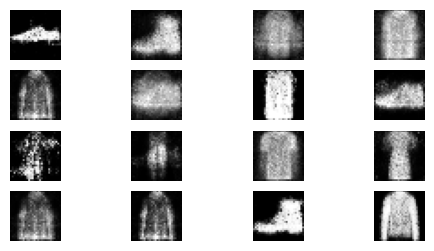

 42%|████▏     | 21/50 [00:57<01:12,  2.51s/it]

Time for epoch 21 is 2.6612021923065186 sec
Training started with  epoch 22 with 469 batches...
Losses after epoch    22: generator 2.368, discriminator 0.551, real_score 84.60%, fake_score 20.16%


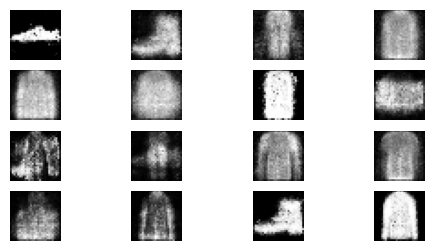

 44%|████▍     | 22/50 [01:00<01:09,  2.49s/it]

Time for epoch 22 is 2.438871145248413 sec
Training started with  epoch 23 with 469 batches...
Losses after epoch    23: generator 2.221, discriminator 0.729, real_score 75.68%, fake_score 20.69%


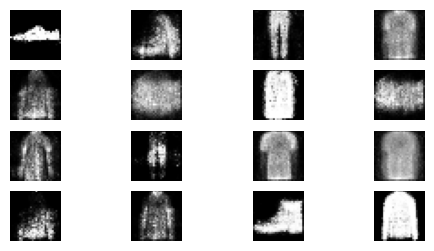

 46%|████▌     | 23/50 [01:02<01:05,  2.44s/it]

Time for epoch 23 is 2.3235361576080322 sec
Training started with  epoch 24 with 469 batches...
Losses after epoch    24: generator 1.737, discriminator 0.647, real_score 75.81%, fake_score 22.27%


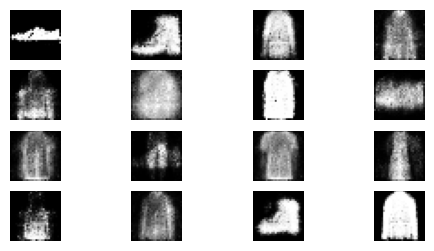

 48%|████▊     | 24/50 [01:04<01:04,  2.47s/it]

Time for epoch 24 is 2.5241482257843018 sec
Training started with  epoch 25 with 469 batches...
Losses after epoch    25: generator 2.113, discriminator 0.648, real_score 77.05%, fake_score 21.11%


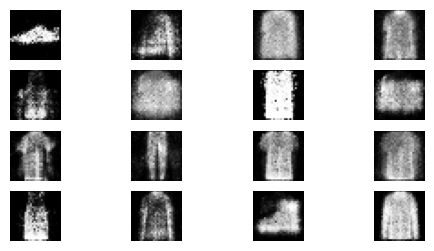

 50%|█████     | 25/50 [01:07<01:03,  2.53s/it]

Time for epoch 25 is 2.6829147338867188 sec
Training started with  epoch 26 with 469 batches...
Losses after epoch    26: generator 1.924, discriminator 0.772, real_score 75.56%, fake_score 24.68%


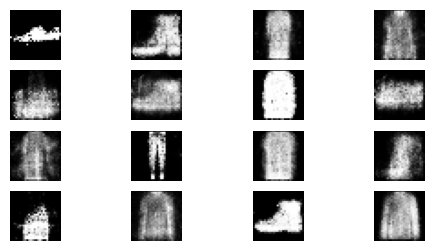

 52%|█████▏    | 26/50 [01:09<00:59,  2.48s/it]

Time for epoch 26 is 2.3518476486206055 sec
Training started with  epoch 27 with 469 batches...
Losses after epoch    27: generator 1.458, discriminator 0.801, real_score 79.39%, fake_score 30.01%


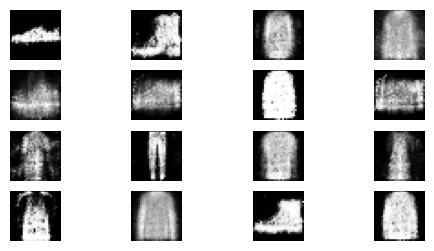

 54%|█████▍    | 27/50 [01:12<00:55,  2.43s/it]

Time for epoch 27 is 2.298858165740967 sec
Training started with  epoch 28 with 469 batches...
Losses after epoch    28: generator 2.419, discriminator 0.783, real_score 73.18%, fake_score 18.19%


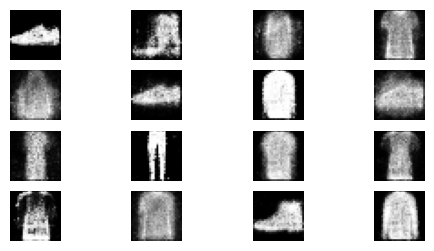

 56%|█████▌    | 28/50 [01:14<00:52,  2.41s/it]

Time for epoch 28 is 2.362436532974243 sec
Training started with  epoch 29 with 469 batches...
Losses after epoch    29: generator 2.613, discriminator 0.469, real_score 82.48%, fake_score 14.42%


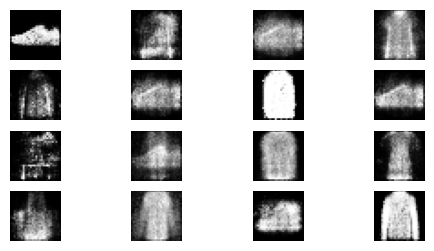

 58%|█████▊    | 29/50 [01:17<00:52,  2.48s/it]

Time for epoch 29 is 2.659014940261841 sec
Training started with  epoch 30 with 469 batches...
Losses after epoch    30: generator 1.855, discriminator 0.903, real_score 74.36%, fake_score 25.50%


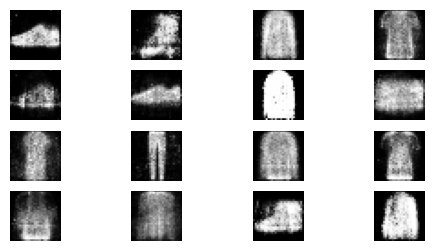

 60%|██████    | 30/50 [01:20<00:51,  2.57s/it]

Time for epoch 30 is 2.7681093215942383 sec
Training started with  epoch 31 with 469 batches...
Losses after epoch    31: generator 1.510, discriminator 0.996, real_score 67.32%, fake_score 31.52%


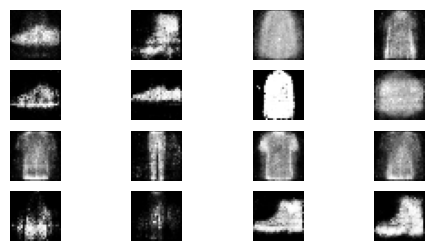

 62%|██████▏   | 31/50 [01:22<00:47,  2.50s/it]

Time for epoch 31 is 2.3313190937042236 sec
Training started with  epoch 32 with 469 batches...
Losses after epoch    32: generator 2.537, discriminator 0.545, real_score 80.81%, fake_score 16.64%


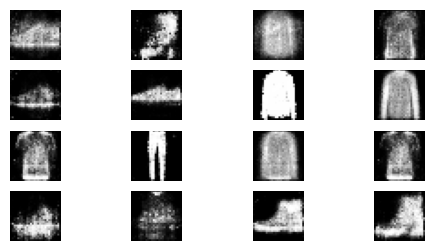

 64%|██████▍   | 32/50 [01:24<00:44,  2.48s/it]

Time for epoch 32 is 2.4426679611206055 sec
Training started with  epoch 33 with 469 batches...
Losses after epoch    33: generator 3.369, discriminator 0.654, real_score 78.23%, fake_score 14.22%


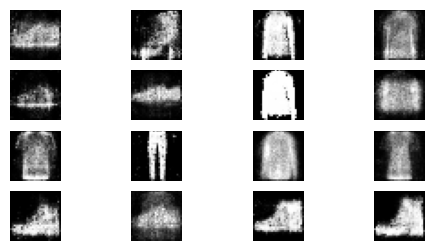

 66%|██████▌   | 33/50 [01:27<00:41,  2.45s/it]

Time for epoch 33 is 2.362264633178711 sec
Training started with  epoch 34 with 469 batches...
Losses after epoch    34: generator 1.938, discriminator 0.861, real_score 72.61%, fake_score 26.01%


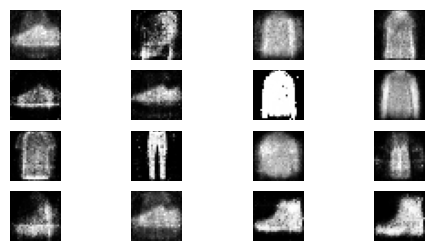

 68%|██████▊   | 34/50 [01:29<00:40,  2.51s/it]

Time for epoch 34 is 2.658266544342041 sec
Training started with  epoch 35 with 469 batches...
Losses after epoch    35: generator 2.442, discriminator 0.597, real_score 81.40%, fake_score 18.91%


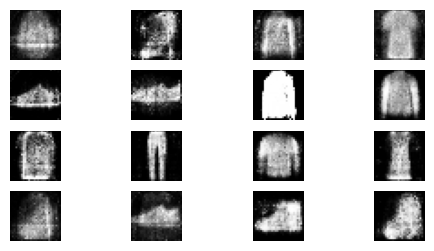

 70%|███████   | 35/50 [01:32<00:37,  2.51s/it]

Time for epoch 35 is 2.4925191402435303 sec
Training started with  epoch 36 with 469 batches...
Losses after epoch    36: generator 2.034, discriminator 0.813, real_score 76.73%, fake_score 24.16%


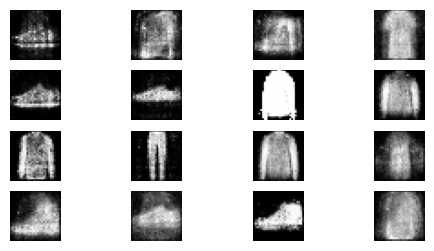

 72%|███████▏  | 36/50 [01:34<00:34,  2.46s/it]

Time for epoch 36 is 2.3366026878356934 sec
Training started with  epoch 37 with 469 batches...
Losses after epoch    37: generator 2.287, discriminator 0.717, real_score 77.14%, fake_score 20.91%


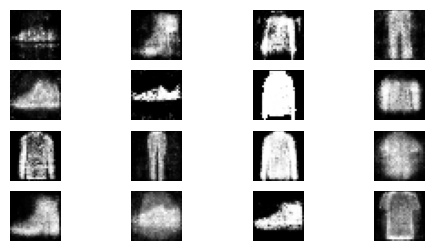

 74%|███████▍  | 37/50 [01:37<00:32,  2.48s/it]

Time for epoch 37 is 2.536681890487671 sec
Training started with  epoch 38 with 469 batches...
Losses after epoch    38: generator 2.713, discriminator 0.681, real_score 75.18%, fake_score 17.31%


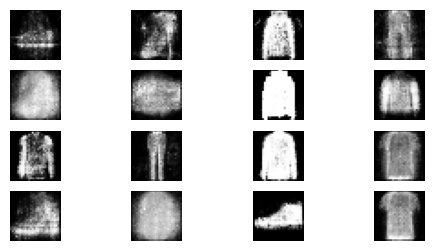

 76%|███████▌  | 38/50 [01:39<00:29,  2.46s/it]

Time for epoch 38 is 2.402902841567993 sec
Training started with  epoch 39 with 469 batches...
Losses after epoch    39: generator 2.409, discriminator 0.555, real_score 81.08%, fake_score 16.31%


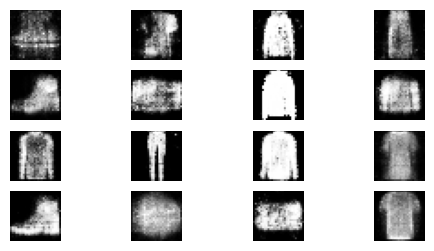

 78%|███████▊  | 39/50 [01:42<00:27,  2.51s/it]

Time for epoch 39 is 2.6233973503112793 sec
Training started with  epoch 40 with 469 batches...
Losses after epoch    40: generator 1.622, discriminator 0.872, real_score 75.21%, fake_score 29.59%


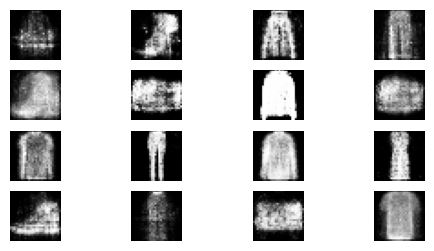

 80%|████████  | 40/50 [01:44<00:24,  2.46s/it]

Time for epoch 40 is 2.347745895385742 sec
Training started with  epoch 41 with 469 batches...
Losses after epoch    41: generator 2.477, discriminator 0.650, real_score 74.36%, fake_score 15.95%


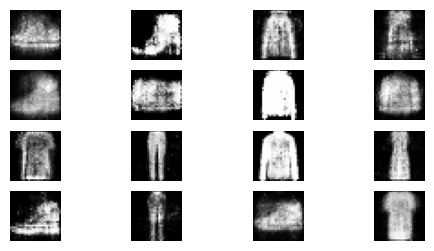

 82%|████████▏ | 41/50 [01:46<00:21,  2.40s/it]

Time for epoch 41 is 2.2529804706573486 sec
Training started with  epoch 42 with 469 batches...
Losses after epoch    42: generator 2.203, discriminator 0.879, real_score 71.95%, fake_score 22.23%


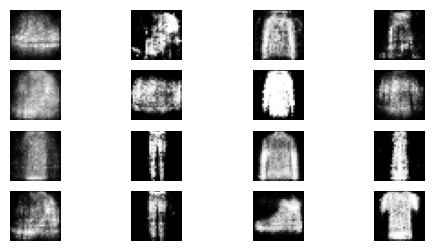

 84%|████████▍ | 42/50 [01:49<00:18,  2.37s/it]

Time for epoch 42 is 2.2931251525878906 sec
Training started with  epoch 43 with 469 batches...
Losses after epoch    43: generator 2.208, discriminator 0.851, real_score 71.55%, fake_score 20.87%


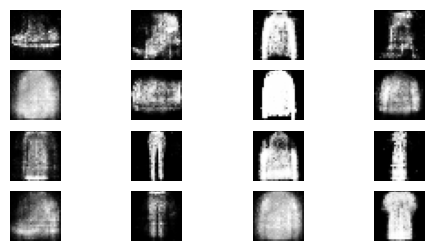

 86%|████████▌ | 43/50 [01:51<00:16,  2.43s/it]

Time for epoch 43 is 2.5622613430023193 sec
Training started with  epoch 44 with 469 batches...
Losses after epoch    44: generator 1.774, discriminator 0.822, real_score 76.90%, fake_score 27.88%


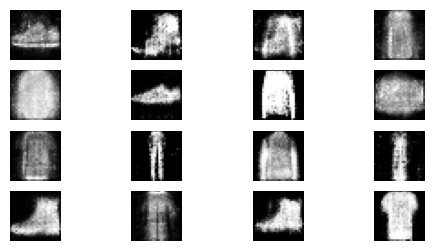

 88%|████████▊ | 44/50 [01:54<00:14,  2.42s/it]

Time for epoch 44 is 2.3925325870513916 sec
Training started with  epoch 45 with 469 batches...
Losses after epoch    45: generator 1.780, discriminator 0.718, real_score 78.61%, fake_score 26.57%


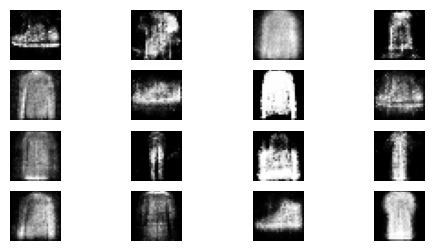

 90%|█████████ | 45/50 [01:56<00:11,  2.39s/it]

Time for epoch 45 is 2.3376731872558594 sec
Training started with  epoch 46 with 469 batches...
Losses after epoch    46: generator 1.302, discriminator 1.319, real_score 61.27%, fake_score 38.98%


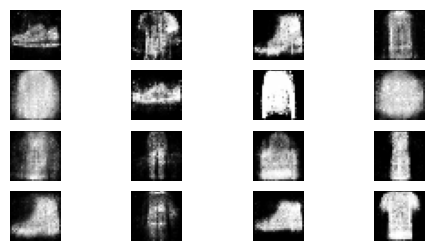

 92%|█████████▏| 46/50 [01:58<00:09,  2.37s/it]

Time for epoch 46 is 2.3220839500427246 sec
Training started with  epoch 47 with 469 batches...
Losses after epoch    47: generator 2.708, discriminator 0.835, real_score 76.50%, fake_score 20.52%


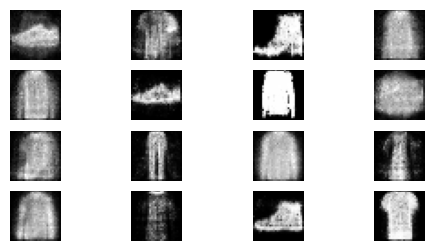

 94%|█████████▍| 47/50 [02:01<00:07,  2.38s/it]

Time for epoch 47 is 2.393455982208252 sec
Training started with  epoch 48 with 469 batches...
Losses after epoch    48: generator 1.497, discriminator 0.742, real_score 77.66%, fake_score 29.13%


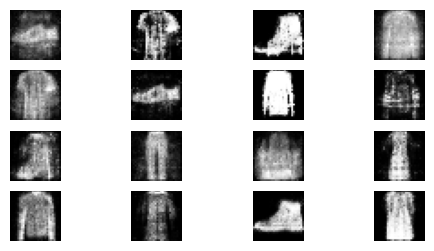

 96%|█████████▌| 48/50 [02:03<00:04,  2.48s/it]

Time for epoch 48 is 2.6924543380737305 sec
Training started with  epoch 49 with 469 batches...
Losses after epoch    49: generator 1.020, discriminator 1.339, real_score 59.59%, fake_score 41.37%


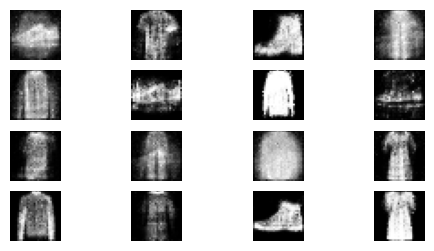

 98%|█████████▊| 49/50 [02:06<00:02,  2.43s/it]

Time for epoch 49 is 2.331812858581543 sec
Training started with  epoch 50 with 469 batches...
Losses after epoch    50: generator 1.380, discriminator 0.938, real_score 67.80%, fake_score 32.21%


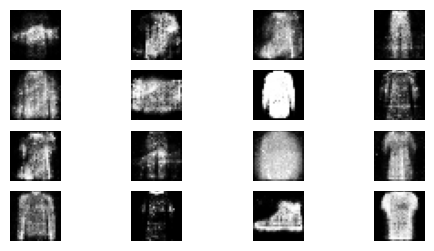

100%|██████████| 50/50 [02:08<00:00,  2.58s/it]

Time for epoch 50 is 2.578904867172241 sec


In [23]:
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(
                                                                        train_dataset, 
                                                                        epochs = epochs)


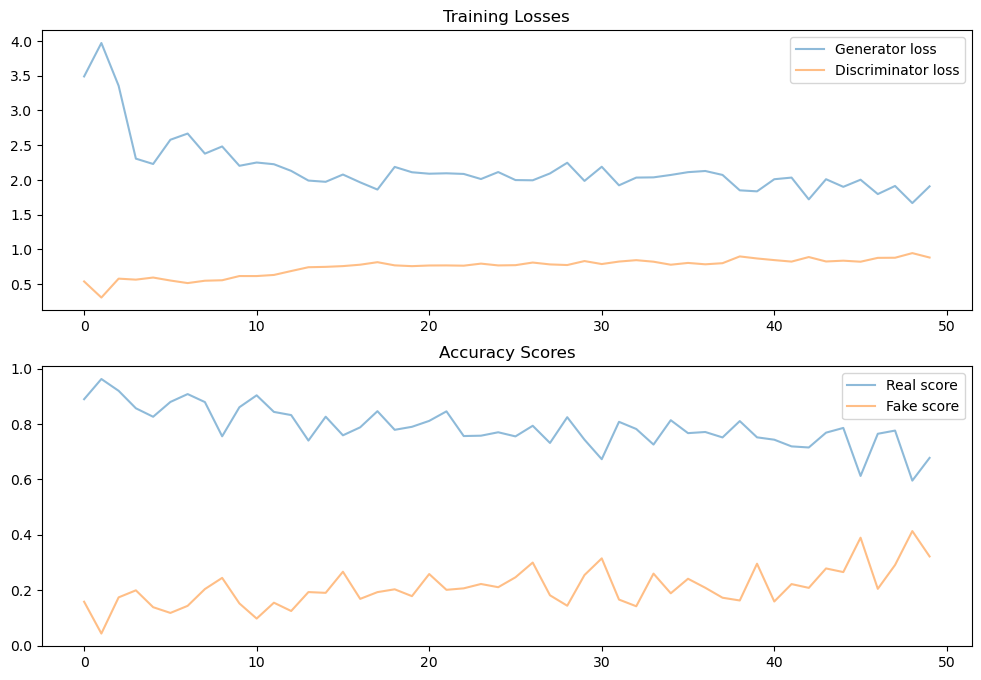

In [24]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize = (12, 8))

ax1.plot(gen_loss_epochs, label = 'Generator loss', alpha = 0.5)
ax1.plot(disc_loss_epochs, label = 'Discriminator loss', alpha = 0.5)
ax1.legend()

ax1.set_title('Training Losses')
ax2.plot(real_score_list, label = 'Real score', alpha = 0.5)
ax2.plot(fake_score_list, label = 'Fake score', alpha = 0.5)
ax2.set_title('Accuracy Scores')

ax2.legend()